In [2]:
import numpy as np
import pandas as pd
from hmmlearn import hmm

In [3]:
df = pd.read_csv('/home/lab/Desktop/ReCoDE-HMMs-for-the-discovery-of-behavioural-states/data/recode_data_small.csv', index_col = 'id')

/tmp/ipykernel_11479/1563418149.py:1: DtypeWarning: Columns (10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/home/lab/Desktop/ReCoDE-HMMs-for-the-discovery-of-behavioural-states/data/recode_data_small.csv', index_col = 'id')


### First we need to intialise our categorical HMM from hmm learn 
### Link to the hmmlearn documnetation -- https://hmmlearn.readthedocs.io/en/latest/api.html

In [1]:
observables = ['immobile', 'micro movements', 'walking']
hidden_states = ['deep sleep', 'light sleep', 'quiet awake', 'active awake']

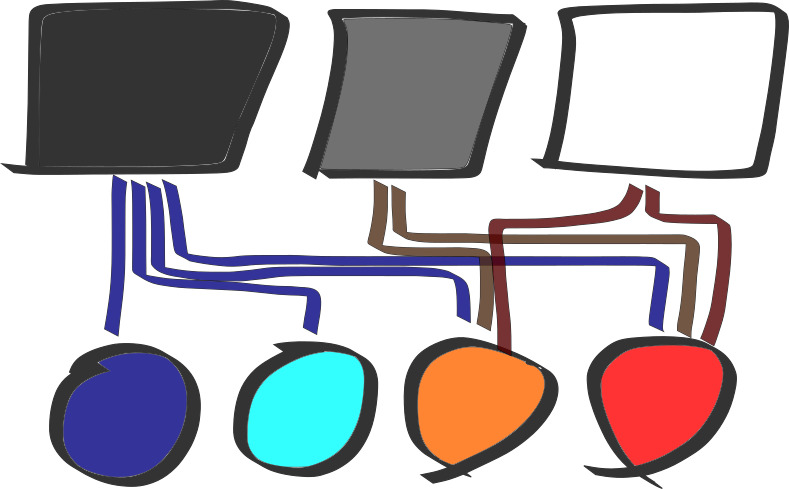

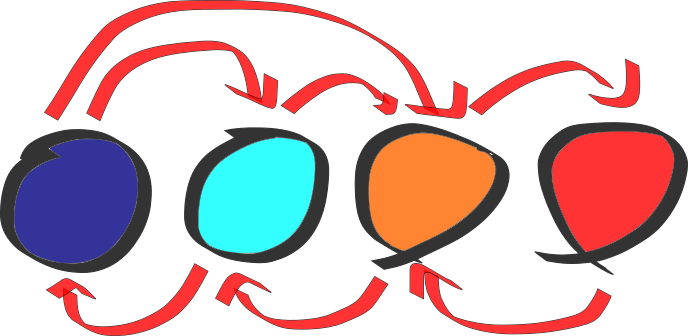

### When training a HMM you need to state the architecure of the transmissions between states. Commonly you will have every state being able to transmit into the next, however this is often not the case with biological examples where there are intermediatory states. The hmmlearn models give you the option to set the transmission, emission, and starting probabilities. 
### For this tutorial we'll just set the transmission and emission probablities

In [ ]:
# Following on from the first part of the tutorial, each row in the matrix is a hidden state and each column is the state it is transitioning into
# Where we give it a zero value it tells the model that these states can't transition into each other
# Taking the first row to be "deep sleep", the first entry is its transition probablity into itself, the next is into "light sleep", the next is "quiet awake", and finally we have its transition into "active awake"
# The next row is for "light sleep", but the columns stay the same, so the first entry is the transtion probabilty into "deep sleep", the second entry is for itself, and then so on.
# Remember the sum of each row must equal 1
t_prob = np.array([[0.6, 0.25, 0.15, 0.0],
                    [0.25, 0.6, 0.15, 0.0],
                    [0.0, 0.2, 0.5, 0.3],
                    [0.0, 0.0, 0.2, 0.8]])

# We now do the same for the emission probabilities
em_prob =  np.array([[1.0, 0.0, 0.0],
                    [1.0, 0.0, 0.0],
                    [0.2, 0.5, 0.4],
                    [0.05 0.25, 0.7]])

### With the above starting transition and emission probabilities we could run the training and chose the model with the best score thinking we've got the best we could with the data and time we have. However, you can run into a machine learning problem called local minima, where if you start from the same point everytime when training the model will optimise to the best score in that local area. Whereas, in reality there are much better parameters the model misses out on, see the pciture below. If we start at the red mark and iterate new parameters it will always fall into the shallower parameters. 

### To get round this it's best to randomise your starting parameters everytime so your liklihood of finding the global minima is greater. The hmmlearn models has this built in, where if you don't set the probabilities beforehand it will randomise them. However, you can't tell it to keep some transmissions or emissions to be 0, losing the architecture you want. So, we'll have to make our own version of it!

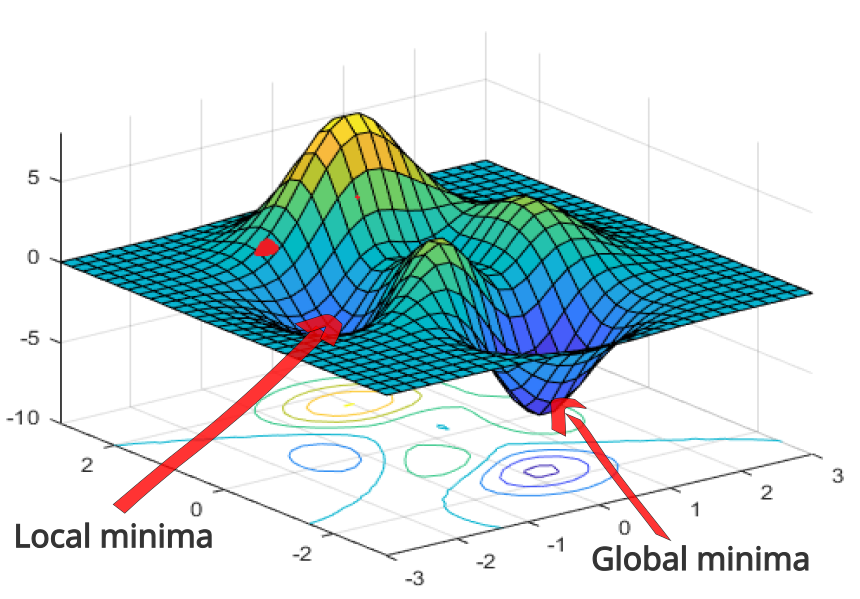

In [ ]:
t_prob = np.array([['rand', 'rand', 'rand', 0.0],
                    ['rand', 'rand', 'rand', 0.0],
                    [0.0, 'rand', 'rand', 'rand'],
                    [0.0, 0.0, 'rand', 'rand']])


em_prob =  np.array([[1.0, 0.0, 0.0],
                    [1.0, 0.0, 0.0],
                    ['rand', 'rand', 'rand'],
                    ['rand', 'rand', 'rand']])

In [ ]:
if start_probs is None:
    init_params += 's'
else:
    s_prob = np.array([[np.random.random() if y == 'rand' else y for y in x] for x in start_probs], dtype = np.float64)
    s_prob = np.array([[y / sum(x) for y in x] for x in t_prob], dtype = np.float64)
    h.startprob_ = s_prob

if trans_probs is None:
    init_params += 't'
else:
    # replace 'rand' with a new random number being 0-1
    t_prob = np.array([[np.random.random() if y == 'rand' else y for y in x] for x in trans_probs], dtype = np.float64)
    t_prob = np.array([[y / sum(x) for y in x] for x in t_prob], dtype = np.float64)
    h.transmat_ = t_prob

if emiss_probs is None:
    init_params += 'e'
else:
    # replace 'rand' with a new random number being 0-1
    em_prob = np.array([[np.random.random() if y == 'rand' else y for y in x] for x in emiss_probs], dtype = np.float64)
    em_prob = np.array([[y / sum(x) for y in x] for x in em_prob], dtype = np.float64)
    h.emissionprob_ = em_prob

In [ ]:
# lets intialise our model
model = hmm.CategoricalHMM(n_components = len(hidden_states), n_features = len(observables), n_iter = 100, tol = 10, params = 'ste')

In [ ]:
# split runs into test and train lists
test_train_split = round(len(gb) * (test_size/100))
rand_runs = np.random.permutation(gb)
train = rand_runs[test_train_split:]
test = rand_runs[:test_train_split]

In [ ]:
def reshape(dataframe):

## Idea set them a task of creating a singular function that intialises, transforms, and trains the data

In [ ]:
def hmm_train(dataframe, states, observables, var_column, file_name, trans_probs = None, emiss_probs = None, start_probs = None, iterations = 10, hmm_iterations = 100, tol = 50, t_column = 't', bin_time = 60, test_size = 10, verbose = False):
    """

    There must be no NaNs in the training data

    Resultant hidden markov models will be saved as a .pkl file if file_name is provided
    Final trained model probability matrices will be printed to terminal at the end of the run time

    Params:
    @states = list of sting(s), names of hidden states for the model to train to
    @observables = list of string(s), names of the observable states for the model to train to.
    The length must be the same number as the different categories in you movement column.
    @trans_probs = numpy array, transtion probability matrix with shape 'len(states) x len(states)', 0's restrict the model from training any tranisitons between those states
    @emiss_probs = numpy array, emission probability matrix with shape 'len(observables) x len(observables)', 0's same as above
    @start_probs = numpy array, starting probability matrix with shape 'len(states) x 0', 0's same as above
    @var_column = string, name for the column containing the variable of choice to train the model
    @iterations = int, only used if random is True, number of loops using a different randomised starting matrices, default is 10
    @hmm_iterations = int, argument to be passed to hmmlearn, number of iterations of parameter updating without reaching tol before it stops, default is 100
    @tol = int, convergence threshold, EM will stop if the gain in log-likelihood is below this value, default is 50
    @t_column = string, name for the column containing the time series data, default is 't'
    @bin_time = int, the time in seconds the data will be binned to before the training begins, default is 60 (i.e 1 min)
    @file_name = string, name of the .pkl file the resultant trained model will be saved to, if left as '' and random is False the model won't be saved, default is ''
    @verbose = (bool, optional), argument for hmmlearn, whether per-iteration convergence reports are printed to terminal

    returns a trained hmmlearn HMM Multinomial object
    """
    
    if file_name.endswith('.pkl') is False:
        raise TypeError('enter a file name and type (.pkl) for the hmm object to be saved under')

    n_states = len(states)
    n_obs = len(observables)

    hmm_df = self.copy(deep = True)

    def bin_to_list(data, t_var, mov_var, bin):
        """ 
        Bins the time to the given integer and creates a nested list of the movement column by id
        """
        stat = 'max'
        data = data.reset_index()
        t_delta = data[t_column].iloc[1] - data[t_column].iloc[0]
        if t_delta != bin:
            data[t_var] = data[t_var].map(lambda t: bin * floor(t / bin))
            bin_gb = data.groupby(['id', t_var]).agg(**{
                mov_var : (var_column, stat)
            })file_name
            bin_gb.reset_index(level = 1, inplace = True)
            gb = bin_gb.groupby('id')[mov_var].apply(np.array)
        else:
            gb = data.groupby('id')[mov_var].apply(np.array)
        return gb

    if var_column == 'beam_crosses':
        hmm_df['active'] = np.where(hmm_df[var_column] == 0, 0, 1)
        gb = bin_to_list(hmm_df, t_var = t_column, mov_var = var_column, bin = bin_time)

    elif var_column == 'moving':
        hmm_df[var_column] = np.where(hmm_df[var_column] == True, 1, 0)
        gb = bin_to_list(hmm_df, t_var = t_column, mov_var = var_column, bin = bin_time)

    else:
        gb = bin_to_list(hmm_df, t_var = t_column, mov_var = var_column, bin = bin_time)

    # split runs into test and train lists
    test_train_split = round(len(gb) * (test_size/100))
    rand_runs = np.random.permutation(gb)
    train = rand_runs[test_train_split:]
    test = rand_runs[:test_train_split]

    len_seq_train = [len(ar) for ar in train]
    len_seq_test = [len(ar) for ar in test]

    seq_train = np.concatenate(train, 0)
    seq_train = seq_train.reshape(-1, 1)
    seq_test = np.concatenate(test, 0)
    seq_test = seq_test.reshape(-1, 1)

    for i in range(iterations):
        print(f"Iteration {i+1} of {iterations}")
        
        init_params = ''
        # h = hmm.MultinomialHMM(n_components = n_states, n_iter = hmm_iterations, tol = tol, params = 'ste', verbose = verbose)
        h = hmm.CategoricalHMM(n_components = n_states, n_iter = hmm_iterations, tol = tol, params = 'ste', verbose = verbose)

        if start_probs is None:
            init_params += 's'
        else:
            s_prob = np.array([[np.random.random() if y == 'rand' else y for y in x] for x in start_probs], dtype = np.float64)
            s_prob = np.array([[y / sum(x) for y in x] for x in t_prob], dtype = np.float64)
            h.startprob_ = s_prob

        if trans_probs is None:
            init_params += 't'
        else:
            # replace 'rand' with a new random number being 0-1
            t_prob = np.array([[np.random.random() if y == 'rand' else y for y in x] for x in trans_probs], dtype = np.float64)
            t_prob = np.array([[y / sum(x) for y in x] for x in t_prob], dtype = np.float64)
            h.transmat_ = t_prob

        if emiss_probs is None:
            init_params += 'e'
        else:
            # replace 'rand' with a new random number being 0-1
            em_prob = np.array([[np.random.random() if y == 'rand' else y for y in x] for x in emiss_probs], dtype = np.float64)
            em_prob = np.array([[y / sum(x) for y in x] for x in em_prob], dtype = np.float64)
            h.emissionprob_ = em_prob

        h.init_params = init_params
        h.n_features = n_obs # number of emission states

        # call the fit function on the dataset input
        h.fit(seq_train, len_seq_train)

        # Boolean output of if the number of runs convererged on set of appropriate probabilites for s, t, an e
        print("True Convergence:" + str(h.monitor_.history[-1] - h.monitor_.history[-2] < h.monitor_.tol))
        print("Final log liklihood score:" + str(h.score(seq_train, len_seq_train)))

        if i == 0:
            try:
                h_old = pickle.load(open(file_name, "rb"))
                if h.score(seq_test, len_seq_test) > h_old.score(seq_test, len_seq_test):
                    print('New Matrix:')
                    df_t = pd.DataFrame(h.transmat_, index = states, columns = states)
                    print(tabulate(df_t, headers = 'keys', tablefmt = "github") + "\n")
                    
                    with open(file_name, "wb") as file: pickle.dump(h, file)
            except OSError as e:
                with open(file_name, "wb") as file: pickle.dump(h, file)

        else:
            h_old = pickle.load(open(file_name, "rb"))
            if h.score(seq_test, len_seq_test) > h_old.score(seq_test, len_seq_test):
                print('New Matrix:')
                df_t = pd.DataFrame(h.transmat_, index = states, columns = states)
                print(tabulate(df_t, headers = 'keys', tablefmt = "github") + "\n")
                with open(file_name, "wb") as file: pickle.dump(h, file)

        if i+1 == iterations:
            h = pickle.load(open(file_name, "rb"))
            #print tables of trained emission probabilties, not accessible as objects for the user
            self._hmm_table(start_prob = h.startprob_, trans_prob = h.transmat_, emission_prob = h.emissionprob_, state_names = states, observable_names = observables)
            return h


In [ ]:
def _hmm_table(start_prob, trans_prob, emission_prob, state_names, observable_names):
    """ 
    Prints a formatted table of the probabilities from a hmmlearn MultinomialHMM object
    """
    df_s = pd.DataFrame(start_prob)
    df_s = df_s.T
    df_s.columns = state_names
    print("Starting probabilty table: ")
    print(tabulate(df_s, headers = 'keys', tablefmt = "github") + "\n")
    print("Transition probabilty table: ")
    df_t = pd.DataFrame(trans_prob, index = state_names, columns = state_names)
    print(tabulate(df_t, headers = 'keys', tablefmt = "github") + "\n")
    print("Emission probabilty table: ")
    df_e = pd.DataFrame(emission_prob, index = state_names, columns = observable_names)
    print(tabulate(df_e, headers = 'keys', tablefmt = "github") + "\n")

In [ ]:
def hmm_display(hmm, states, observables):
    """
    Prints to screen the transion probabilities for the hidden state and observables for a given hmmlearn hmm object
    """
    self._hmm_table(start_prob = hmm.startprob_, trans_prob = hmm.transmat_, emission_prob = hmm.emissionprob_, state_names = states, observable_names = observables)